In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import geocoder 
from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

In [57]:
def getNeibghborhood():
    req = requests.get("https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver")
    neighborhoods = BeautifulSoup(req.text)
    items = neighborhoods.find_all("li")
    dict0 = {}
    for i in range(8, 29):
        try:
            dict0["Neighborhood"].append(items[i].text)
        except:
            dict0["Neighborhood"] = []
    return pd.DataFrame(dict0)

def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Vancouver, Canada'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

# get top 100 venues that are in each neighborhoods within a radius of 500 meters
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CLIENT_ID = "AA405KPT040BGEPDFRROHTRLTYDACBRK1DWXYQ0X5E4TVWLJ"
CLIENT_SECRET = "QO3DV3PDE0MUIFCODTOMPNUFHPDC4IXXYC0JXXDXCP2BGWSR"
VERSION = '20180605'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[5:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [42]:
# Scape data from open-souce databases 
neighborhoods = getNeibghborhood()
print("- finished scraping all neighborhoods")
coords = [get_latlng(neighborhood) for neighborhood in neighborhoods["Neighborhood"].tolist()]
print("- finished scraping coordinates for all neiborhoods")
neighborhoods= pd.concat([neighborhoods, pd.DataFrame(columns=["Latitude", "Longitude"], data=coords)], axis=1)
vancouver_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
print("- finished scraping top 100 venues in each neighborhood")

- finished scraping all neighborhoods
- finished scraping coordinates for all neiborhoods
Downtown
Dunbar-Southlands
Fairview
Grandview-Woodland
Hastings-Sunrise
Kensington-Cedar Cottage
Kerrisdale
Killarney
Kitsilano
Marpole
Mount Pleasant
Oakridge
Renfrew-Collingwood
Riley Park
Shaughnessy
South Cambie
Strathcona
Sunset
Victoria-Fraserview
West End
- finished scraping top 100 venues in each neighborhood


In [53]:
print(f"- There are {len(vancouver_venues.Neighborhood.unique())} neighborhoods in Vancouver;\n- There are {vancouver_venues.shape[0]} observations in the dataframe.")
vancouver_venues


- There are 20 neighborhoods in Vancouver;
- There are 510 observations in the dataframe.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Downtown,49.28108,-123.11590,Gotham Steakhouse & Cocktail Bar,49.282830,-123.115865,Steakhouse
1,Downtown,49.28108,-123.11590,L'Hermitage,49.280139,-123.117480,Hotel
2,Downtown,49.28108,-123.11590,Medina Café,49.280565,-123.116859,Breakfast Spot
3,Downtown,49.28108,-123.11590,JJ Bean,49.279382,-123.115181,Coffee Shop
4,Downtown,49.28108,-123.11590,Abercrombie & Fitch,49.282274,-123.118685,Clothing Store
...,...,...,...,...,...,...,...
505,West End,49.28619,-123.13373,Ramen Takanotsume,49.290172,-123.134328,Ramen Restaurant
506,West End,49.28619,-123.13373,Olympia Pizza,49.289408,-123.138461,Greek Restaurant
507,West End,49.28619,-123.13373,Shoppers Drug Mart,49.289057,-123.138890,Pharmacy
508,West End,49.28619,-123.13373,Burger King,49.288901,-123.138953,Fast Food Restaurant


In [60]:
# Apply one-hot encoding to Venue Category
ohe = OneHotEncoder(sparse=False, dtype=int)

vancouver_oht = pd.concat((toronto_venues, pd.DataFrame(ohe.fit_transform(vancouver_venues[["Venue Category"]]),
                           columns=ohe.categories_[0])),
          axis=1)
vancouver_oht

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Accessories Store,Art Gallery,Arts & Crafts Store,...,Toy / Game Store,Trade School,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Downtown,49.28108,-123.11590,Gotham Steakhouse & Cocktail Bar,49.282830,-123.115865,Steakhouse,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Downtown,49.28108,-123.11590,L'Hermitage,49.280139,-123.117480,Hotel,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Downtown,49.28108,-123.11590,Medina Café,49.280565,-123.116859,Breakfast Spot,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Downtown,49.28108,-123.11590,JJ Bean,49.279382,-123.115181,Coffee Shop,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Downtown,49.28108,-123.11590,Abercrombie & Fitch,49.282274,-123.118685,Clothing Store,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,West End,49.28619,-123.13373,Ramen Takanotsume,49.290172,-123.134328,Ramen Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
506,West End,49.28619,-123.13373,Olympia Pizza,49.289408,-123.138461,Greek Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0
507,West End,49.28619,-123.13373,Shoppers Drug Mart,49.289057,-123.138890,Pharmacy,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,West End,49.28619,-123.13373,Burger King,49.288901,-123.138953,Fast Food Restaurant,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
vancouver_grouped = vancouver_oht.groupby('Neighborhood').mean().reset_index()

# Generate the top 10 most common venue categories in each neighborhood 
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = vancouver_grouped['Neighborhood']

for ind in np.arange(vancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted = neighborhoods_venues_sorted.set_index("Neighborhood")

In [82]:
vancouver_grouped

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,Accessories Store,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Workshop,...,Toy / Game Store,Trade School,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Downtown,49.28108,-123.11590,49.282004,-123.115974,0.00000,0.027027,0.013514,0.000000,0.000000,...,0.013514,0.013514,0.000000,0.027027,0.027027,0.000000,0.013514,0.000000,0.000000,0.000000
1,Dunbar-Southlands,49.24996,-123.18051,49.247808,-123.185168,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Fairview,49.26613,-123.13323,49.265735,-123.134345,0.00000,0.000000,0.052632,0.026316,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.000000
3,Grandview-Woodland,49.28296,-123.06934,49.282431,-123.068337,0.00000,0.000000,0.000000,0.034483,0.034483,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Hastings-Sunrise,49.28021,-123.02869,49.280814,-123.026602,0.00000,0.000000,0.000000,0.045455,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kensington-Cedar Cottage,49.24973,-123.06986,49.249334,-123.072549,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000
6,Kerrisdale,49.22097,-123.15073,49.221066,-123.151725,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Killarney,49.22670,-123.03657,49.225485,-123.042370,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Kitsilano,49.26833,-123.16542,49.267377,-123.166818,0.00000,0.000000,0.026316,0.000000,0.000000,...,0.026316,0.000000,0.000000,0.026316,0.026316,0.000000,0.000000,0.026316,0.026316,0.052632
9,Marpole,49.20067,-123.13053,49.201433,-123.132522,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [92]:
colnames = neighborhoods_venues_sorted.columns.to_list()
#neighborhoods.index.to_list()
colnames

['1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [84]:
vancouver_grouped = vancouver_grouped.set_index("Neighborhood")

In [96]:
neighborhood_names = vancouver_grouped.index.to_list()

In [86]:
vancouver_grouped.loc["Downtown", neighborhoods_venues_sorted.loc["Downtown", "1st Most Common Venue"]]

0.0945945945945946

In [105]:
heatmap_dict = {}
for i in range(len(colnames)):
    for j in range(len(neighborhood_names)+1):
        try:
            heatmap_dict[colnames[i]].append(
                vancouver_grouped.loc[neighborhood_names[j-1], neighborhoods_venues_sorted.loc[neighborhood_names[j-1], colnames[i]]])
        except:
            heatmap_dict[colnames[i]] = []

In [107]:
heatmap_df = pd.DataFrame(index=neighborhood_names, data=heatmap_dict)
heatmap_df

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Downtown,0.094595,0.054054,0.040541,0.040541,0.040541,0.027027,0.027027,0.027027,0.027027,0.027027
Dunbar-Southlands,0.285714,0.142857,0.142857,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
Fairview,0.078947,0.078947,0.078947,0.078947,0.052632,0.052632,0.052632,0.052632,0.052632,0.026316
Grandview-Woodland,0.137931,0.103448,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483
Hastings-Sunrise,0.136364,0.090909,0.090909,0.090909,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455
Kensington-Cedar Cottage,0.133333,0.133333,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
Kerrisdale,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Killarney,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Kitsilano,0.078947,0.078947,0.052632,0.052632,0.052632,0.052632,0.026316,0.026316,0.026316,0.026316
Marpole,0.133333,0.133333,0.133333,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


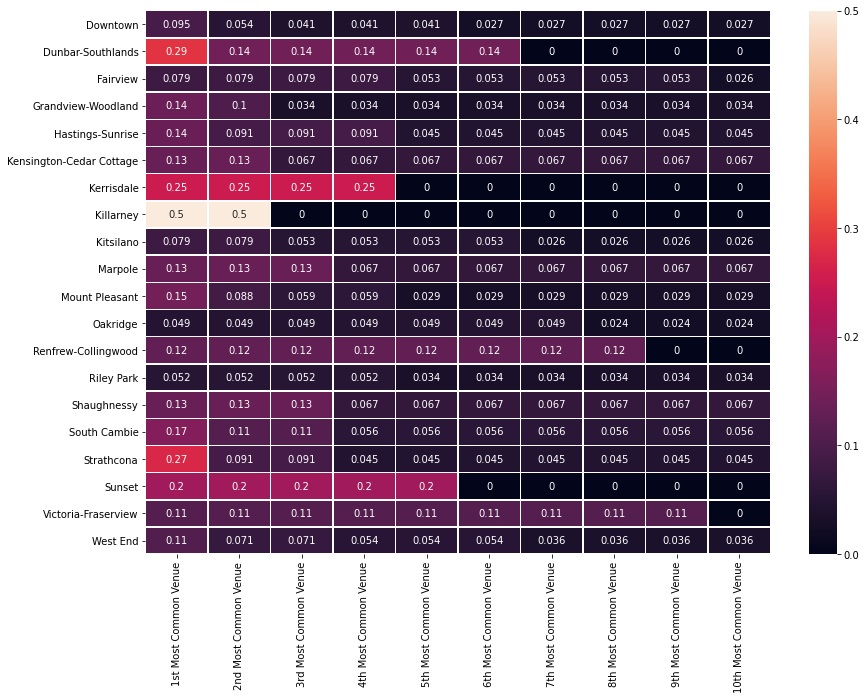

In [141]:
import seaborn as sns
plt.figure(figsize=(14, 10))
ax = sns.heatmap(heatmap_df, linewidths=.5, annot=True)
# Loop over data dimensions and create text annotations.
#for i in range(len(neighborhood_names)):
#    for j in range(len(colnames)):
#        text = ax.text(j, i, labels[i, j][:5],
 #                      ha="center", va="center", color="w")
plt.savefig("heatmap.png")

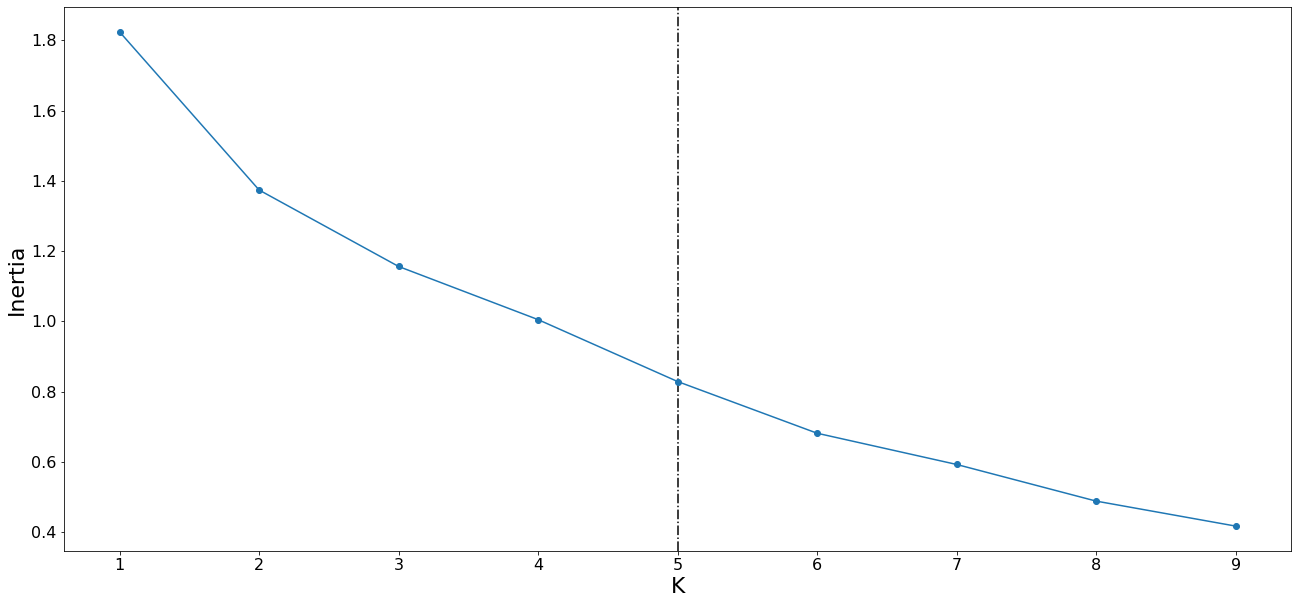

In [62]:
# Cluster neighborhood 
vancouver_grouped_clustering = vancouver_grouped.drop(columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue Latitude', 'Venue Longitude'])


# Use elbow methods to decide k
kmeans = list()
for k in range(1,10):
    kmeans.append(KMeans(n_clusters=k, random_state=0).fit(vancouver_grouped_clustering))
    
    
def plot_elbow(w, h, kmeans):
    plt.figure(figsize = (w,h))
    plt.axvline(x=5, linestyle='-.', c="black")
    plt.plot(range(1,10),[k.inertia_ for k in kmeans], '-o');
    ax = plt.gca()
    ax.tick_params('both', labelsize=(w+h)/2)
    ax.set_xlabel('K', fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
plot_elbow(22,10, kmeans)

In [129]:
df4 = heatmap_df.style.background_gradient()

In [138]:
df4.savefig("heatmap.png")

AttributeError: 'Styler' object has no attribute 'savefig'

In [144]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vancouver_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
vancouver_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [145]:
neighborhoods_venues_sorted.to_csv("neighborhood_venues_sorted.csv")
neighborhoods_venues_sorted

,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,
Downtown,1,Hotel,Café,Seafood Restaurant,Restaurant,Coffee Shop,Steakhouse,Taco Place,Clothing Store,Theater,Concert Hall
Dunbar-Southlands,1,Bank,Mexican Restaurant,Cosmetics Shop,Indian Restaurant,Café,Sushi Restaurant,Yoga Studio,Food Court,Food & Drink Shop,Flower Shop
Fairview,1,Breakfast Spot,Furniture / Home Store,Park,Restaurant,Japanese Restaurant,Arts & Crafts Store,Camera Store,Coffee Shop,Spa,Pharmacy
Grandview-Woodland,3,Brewery,Coffee Shop,Hotel,Liquor Store,Deli / Bodega,Pub,Electronics Store,Fast Food Restaurant,Nightclub,Chinese Restaurant
Hastings-Sunrise,1,Bus Station,Coffee Shop,Soccer Field,Bus Stop,Theme Park Ride / Attraction,Sporting Goods Shop,Chinese Restaurant,Bridal Shop,Sushi Restaurant,Fast Food Restaurant
Kensington-Cedar Cottage,1,Vietnamese Restaurant,Café,Indian Restaurant,Sandwich Place,Burger Joint,Supermarket,Breakfast Spot,Seafood Restaurant,Church,Grocery Store
Kerrisdale,2,Park,Supermarket,Spanish Restaurant,Café,French Restaurant,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fast Food Restaurant
Killarney,4,Pool,Coffee Shop,Yoga Studio,Farmers Market,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Fish Market,Fast Food Restaurant
Kitsilano,1,Coffee Shop,Park,Yoga Studio,Bank,Café,Pizza Place,Pub,Restaurant,Chinese Restaurant,Italian Restaurant


In [66]:
# Get the latitude and longitude of Vancouver
address = 'Vancouver, British Columbia'

geolocator = Nominatim(user_agent="vc_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_grouped['Neighborhood Latitude'], vancouver_grouped['Neighborhood Longitude'], vancouver_grouped['Neighborhood'], vancouver_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('./vancouver_neighborhood_clustering.html')

In [68]:
from IPython.core.display import HTML
HTML(map_clusters._repr_html_())